<a href="https://colab.research.google.com/github/GaryM02/applied_predictive_analytics/blob/main/hard_contrast_vit_siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm  # For using pre-trained models
import os
import random
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from torch.cuda.amp import GradScaler, autocast
import torch.multiprocessing as mp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/PredictiveAnalyticsProject')

Mounted at /content/drive


In [ ]:
class TripletDataset(Dataset):
    def __init__(self, root_dir, model, device='cuda', transform=None, num_images_per_class=10, triplet_fraction=1.0):
        """
        Dataset with precomputed embeddings for hard positive and negative mining.

        Args:
            root_dir (str): Root directory with class folders.
            model (nn.Module): Pretrained model for computing embeddings.
            device (str): Device for embedding computation (e.g., 'cuda' or 'cpu').
            transform (callable, optional): Transformations for the images.
            num_images_per_class (int): Max images per class.
            triplet_fraction (float): Fraction of total triplets to sample.
        """
        if not os.path.exists(root_dir):
            raise ValueError(f"Root directory {root_dir} does not exist.")
        if len(os.listdir(root_dir)) == 0:
            raise ValueError(f"Root directory {root_dir} is empty.")

        self.root_dir = root_dir
        self.model = model
        self.device = device
        self.transform = transform
        self.num_images_per_class = num_images_per_class
        self.triplet_fraction = triplet_fraction

        # Precompute class-to-image mappings
        self.class_to_images = {}
        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                images = [os.path.join(class_path, f) for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
                if len(images) >= 2:  # Ensure at least two images per class
                    random.shuffle(images)
                    self.class_to_images[class_name] = images[:self.num_images_per_class]

        self.classes = list(self.class_to_images.keys())
        self.class_negatives = {
            class_name: [cls for cls in self.classes if cls != class_name]
            for class_name in self.classes
        }

        # Precompute embeddings
        print("Precomputing embeddings for all images...")
        self.image_to_embedding = self.compute_embeddings()

    def compute_embeddings(self):
        """
        Compute embeddings for all images and store in a dictionary.

        Returns:
            dict: Mapping from image paths to embeddings.
        """
        self.model.eval()
        image_to_embedding = {}

        with torch.no_grad():
            for class_name, images in tqdm(self.class_to_images.items(), desc="Embedding Images"):
                for image_path in images:
                    image = self.load_image(image_path).unsqueeze(0).to(self.device)
                    embedding = self.model(image).squeeze(0).cpu()
                    image_to_embedding[image_path] = embedding

        return image_to_embedding

    def __len__(self):
        return int(self.calculate_total_triplets(len(self.classes), self.num_images_per_class) * self.triplet_fraction)

    def calculate_total_triplets(self, num_classes, num_images_per_class):
        """
        Calculate the total number of triplets for metric learning.

        Args:
            num_classes (int): Number of classes (C).
            num_images_per_class (int): Number of images per class (N).

        Returns:
            int: Total number of triplets (T).
        """
        # For one class: Anchor-positive pairs (within class) * negatives (from other classes)
        anchor_positive_pairs = (num_images_per_class * (num_images_per_class - 1)) // 2
        negatives_per_pair = (num_classes - 1) * num_images_per_class

        # Total triplets across all classes
        total_triplets = num_classes * anchor_positive_pairs * negatives_per_pair
        return total_triplets

    def __getitem__(self, index):
        # Select a random anchor class and image
        anchor_class = random.choice(self.classes)
        anchor_images = self.class_to_images[anchor_class]
        anchor_path = random.choice(anchor_images)

        # Retrieve anchor embedding
        anchor_embedding = self.image_to_embedding[anchor_path]

        # Hard positive mining
        positive_path = self.select_hard_positive(anchor_path, anchor_images, anchor_embedding)

        # Hard negative mining
        negative_class = random.choice(self.class_negatives[anchor_class])
        negative_path = self.select_hard_negative(anchor_embedding, self.class_to_images[negative_class])

        # Load positive and negative images
        positive_image = self.load_image(positive_path)
        negative_image = self.load_image(negative_path)

        return self.load_image(anchor_path), positive_image, negative_image

    def select_hard_positive(self, anchor_path, class_images, anchor_embedding):
        """Select the hardest positive sample based on precomputed embeddings."""
        hardest_positive = None
        max_distance = -float("inf")

        for positive_path in class_images:
            if positive_path == anchor_path:
                continue
            positive_embedding = self.image_to_embedding[positive_path]
            distance = F.pairwise_distance(anchor_embedding.unsqueeze(0), positive_embedding.unsqueeze(0)).item()
            if distance > max_distance:
                max_distance = distance
                hardest_positive = positive_path

        return hardest_positive

    def select_hard_negative(self, anchor_embedding, negative_images):
        """Select the hardest negative sample based on precomputed embeddings."""
        hardest_negative = None
        min_distance = float("inf")

        for negative_path in negative_images:
            negative_embedding = self.image_to_embedding[negative_path]
            distance = F.pairwise_distance(anchor_embedding.unsqueeze(0), negative_embedding.unsqueeze(0)).item()
            if distance < min_distance:
                min_distance = distance
                hardest_negative = negative_path

        return hardest_negative

    def load_image(self, image_path):
        """Load an image and apply the transform if provided."""
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image



class SiameseNetwork(nn.Module):
    def __init__(self, backbone_name=None):
        """
        Siamese network with a single backbone.

        Args:
            backbone1_name (str): Name of the backbone (e.g., 'resnet50').
            embedding_dim (int): Dimension of the output embeddings.
        """
        super(SiameseNetwork, self).__init__()

        # Initialize backbone 1 if provided
        if backbone_name:
            self.backbone = timm.create_model(backbone_name, pretrained=True)
            self.backbone.reset_classifier(0)  # Remove classification head
        else:
            raise ValueError("A backbone model must be specified.")

    def forward(self, input1, input2=None, input3=None):
        """
        Forward pass for one, two, or three inputs.

        Args:
            input1 (torch.Tensor): Anchor input.
            input2 (torch.Tensor, optional): Positive input.
            input3 (torch.Tensor, optional): Negative input.

        Returns:
            Embeddings (torch.Tensor): Embedding of the input(s).
        """


        if input2 is None and input3 is None:
            return self.backbone(input1)

        if input3 is None:
            return self.backbone(input1), self.backbone(input2)

        return self.backbone(input1), self.backbone(input2), self.backbone(input3)


class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        positive_distance = F.pairwise_distance(anchor, positive)
        negative_distance = F.pairwise_distance(anchor, negative)
        loss = torch.mean(F.relu(positive_distance - negative_distance + self.margin))
        return loss


# Data Loading
def load_data(batch_size=32, triplet_fraction=1.0, num_train_images_per_class=20, num_val_images_per_class=4, model=None):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    train_dataset = TripletDataset(
        root_dir='data/train',
        transform=train_transform,
        num_images_per_class=num_train_images_per_class,
        triplet_fraction=triplet_fraction,
        model=model,  # Pass the pretrained or partially trained model
        device=device,
    )
    val_dataset = TripletDataset(root_dir='data/validation', transform=val_transform, num_images_per_class=num_val_images_per_class, triplet_fraction=triplet_fraction, model=model, device=device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=6, pin_memory=True)
    return train_loader, val_loader

# Save model state for resume training
def save_checkpoint(model, optimizer, epoch, val_loss, filepath):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'val_loss': val_loss
    }
    torch.save(checkpoint, filepath)

# Load model state for resuming training
def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    val_loss = checkpoint['val_loss']
    return model, optimizer, epoch, val_loss

# Train one epoch
def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    all_labels, all_predictions = [], []

    progress = tqdm(loader, desc="Training", leave=False)
    # Loop over batches
    for anchor, positive, negative in progress:
        # Move data to device
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        with autocast():
            # Forward pass
            anchor_output, positive_output, negative_output = model(anchor, positive, negative)

            # Compute loss
            loss = criterion(anchor_output, positive_output, negative_output)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    return avg_loss

# Validate the model
def validate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        # Loop over batches
        for anchor, positive, negative in tqdm(loader, desc="Validation", leave=False):
            # Move data to device
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            with autocast():
                # Forward pass
                anchor_output, positive_output, negative_output = model(anchor, positive, negative)

                # Compute loss
                loss = criterion(anchor_output, positive_output, negative_output)

            running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    return avg_loss

# Plot metrics
def plot_metrics(metrics):
    plt.figure(figsize=(10, 5))
    for key, values in metrics.items():
        plt.plot(values, label=key)
    plt.legend()
    plt.show()

# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, device, resume_path=None):
    num_epochs = 50
    early_stopping_patience = 15
    early_stopping_counter = 0
    curr_val_loss = 1.0
    metrics = {"train_loss": [], "val_loss": []}
    start_epoch = 0

    # Resume training if a checkpoint is provided
    if resume_path:
        model, optimizer, start_epoch, val_loss = load_checkpoint(resume_path, model, optimizer)
        print(f"Resumed training from epoch {start_epoch} with best Val Loss: {val_loss:.4f}, lr: {optimizer.param_groups[0]['lr']}")

    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device)
        val_loss = validate_model(model, val_loader, criterion, device)

        metrics["train_loss"].append(train_loss)
        metrics["val_loss"].append(val_loss)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")

        scheduler.step(val_loss)

        # Save the best model
        if val_loss < curr_val_loss:
            curr_val_loss = val_loss
            save_checkpoint(model, optimizer, epoch, curr_val_loss, "hard_contrast_vit_siamese_best_model.pth")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        # Early stopping
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    plot_metrics(metrics)

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = SiameseNetwork(
    backbone_name="vit_base_patch16_224_in21k",
).to(device)

checkpoint = torch.load("siamese_best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

<ipython-input-4-6a80a17a3f9f>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("siamese_best_model.pth")


<All keys matched successfully>

In [13]:
# mp.set_start_method('spawn', force=True)



# Data Loading
train_loader, val_loader = load_data(batch_size=32, triplet_fraction=0.1, num_train_images_per_class=5, num_val_images_per_class=2, model=model)



# Define optimizer, scheduler, and loss function
criterion = TripletLoss(margin=0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',          # Reduce LR when the monitored metric stops decreasing
    factor=0.1,          # Multiply LR by this factor
    patience=7,          # Number of epochs to wait before reducing LR
    threshold=1e-4,      # Minimum change to qualify as an improvement
    cooldown=2,          # Number of epochs to wait after reducing LR
    min_lr=1e-6          # Minimum learning rate
)
scaler = GradScaler()

Precomputing embeddings for all images...


Embedding Images: 100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


Precomputing embeddings for all images...


Embedding Images: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-13-e6a11c69a795>:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/15 [00:00<?, ?it/s]<ipython-input-3-e7d6671bc360>:260: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-3-e7d6671bc360>:288: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1870
Val Loss: 8.5496
Epoch 2/50


Train Loss: 0.1771
Val Loss: 0.2135
Epoch 3/50


Train Loss: 0.1804
Val Loss: 0.1690
Epoch 4/50


Train Loss: 0.1830
Val Loss: 0.2450
Epoch 5/50


Train Loss: 0.1646
Val Loss: 0.4138
Epoch 6/50


Train Loss: 0.1811
Val Loss: 0.2874
Epoch 7/50


Train Loss: 0.1736
Val Loss: 0.2347
Epoch 8/50


Train Loss: 0.1634
Val Loss: 0.2343
Epoch 9/50


Train Loss: 0.1702
Val Loss: 0.1648
Epoch 10/50


Train Loss: 0.1727
Val Loss: 0.2206
Epoch 11/50


Train Loss: 0.1725
Val Loss: 0.2561
Epoch 12/50


Train Loss: 0.1814
Val Loss: 0.2542
Epoch 13/50


Train Loss: 0.1854
Val Loss: 0.2431
Epoch 14/50


Train Loss: 0.1598
Val Loss: 0.1870
Epoch 15/50


Train Loss: 0.1692
Val Loss: 0.1014
Epoch 16/50


Train Loss: 0.1515
Val Loss: 0.2530
Epoch 17/50


Train Loss: 0.1562
Val Loss: 0.1915
Epoch 18/50


Train Loss: 0.1724
Val Loss: 0.2575
Epoch 19/50


Train Loss: 0.1636
Val Loss: 0.2202
Epoch 20/50


Train Loss: 0.1570
Val Loss: 0.1666
Epoch 21/50


Train Loss: 0.1466
Val Loss: 0.2760
Epoch 22/50


Train Loss: 0.1562
Val Loss: 0.2045
Epoch 23/50


Train Loss: 0.1582
Val Loss: 0.2510
Epoch 24/50


Train Loss: 0.1656
Val Loss: 0.3253
Epoch 25/50


Train Loss: 0.1443
Val Loss: 0.1703
Epoch 26/50


Train Loss: 0.1372
Val Loss: 0.2560
Epoch 27/50


Train Loss: 0.1440
Val Loss: 0.2836
Epoch 28/50


Train Loss: 0.1398
Val Loss: 0.2145
Epoch 29/50


Train Loss: 0.1558
Val Loss: 0.1936
Epoch 30/50


Train Loss: 0.1302
Val Loss: 0.2052
Early stopping triggered.


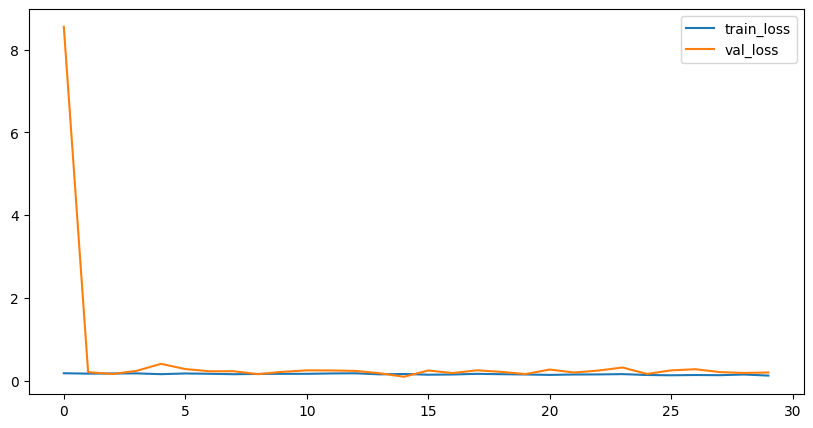

In [14]:
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, device)

In [ ]:
# print state of model
model.state_dict()

In [18]:
load_checkpoint("hard_contrast_vit_siamese_best_model.pth", model, optimizer)

<ipython-input-3-e7d6671bc360>:241: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


(SiameseNetwork(
   (backbone): VisionTransformer(
     (patch_embed): PatchEmbed(
       (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
       (norm): Identity()
     )
     (pos_drop): Dropout(p=0.0, inplace=False)
     (patch_drop): Identity()
     (norm_pre): Identity()
     (blocks): Sequential(
       (0): Block(
         (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
         (attn): Attention(
           (qkv): Linear(in_features=768, out_features=2304, bias=True)
           (q_norm): Identity()
           (k_norm): Identity()
           (attn_drop): Dropout(p=0.0, inplace=False)
           (proj): Linear(in_features=768, out_features=768, bias=True)
           (proj_drop): Dropout(p=0.0, inplace=False)
         )
         (ls1): Identity()
         (drop_path1): Identity()
         (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
         (mlp): Mlp(
           (fc1): Linear(in_features=768, out_features=3072, bias=True)
           

In [ ]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances, recall_score, precision_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


def generate_embeddings(model, loader, device):
    """
    Generate embeddings and labels for all samples in the validation loader.

    Args:
        model (torch.nn.Module): Trained Siamese network.
        loader (torch.utils.data.DataLoader): Validation data loader.
        device (torch.device): Device to use for computation.

    Returns:
        embeddings (numpy.ndarray): Generated embeddings for all samples.
        labels (numpy.ndarray): Corresponding class labels.
    """
    model.eval()
    embeddings, labels = [], []

    with torch.no_grad():
        for images, targets in loader:  # Assuming loader returns (image, label) tuples
            images = images.to(device)
            outputs = model(images)
            embeddings.append(outputs.cpu().numpy())
            labels.append(targets.numpy())

    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)

    return embeddings, labels

def compute_recall_at_k(embeddings, labels, k=5):
    """
    Compute Recall@K for the generated embeddings.

    Args:
        embeddings (numpy.ndarray): Embedding vectors.
        labels (numpy.ndarray): Corresponding class labels.
        k (int): Number of nearest neighbors to consider.

    Returns:
        recall (float): Recall@K value.
    """
    distances = pairwise_distances(embeddings, metric="euclidean")
    recall_at_k = []

    for i in range(len(labels)):
        # Get indices of the K nearest neighbors (excluding itself)
        neighbors = np.argsort(distances[i])[1:k+1]
        # Check if any neighbor has the same label
        recall_at_k.append(any(labels[i] == labels[neighbor] for neighbor in neighbors))

    return np.mean(recall_at_k)

def compute_map(embeddings, labels):
    """
    Compute Mean Average Precision (mAP) for the embeddings.

    Args:
        embeddings (numpy.ndarray): Embedding vectors.
        labels (numpy.ndarray): Corresponding class labels.

    Returns:
        mAP (float): Mean Average Precision score.
    """
    distances = pairwise_distances(embeddings, metric="euclidean")
    average_precisions = []

    for i in range(len(labels)):
        # Get sorted indices based on distances
        neighbors = np.argsort(distances[i])
        relevant = 0
        precision_sum = 0.0

        for rank, neighbor in enumerate(neighbors[1:], start=1):  # Skip self-comparison
            if labels[i] == labels[neighbor]:
                relevant += 1
                precision_sum += relevant / rank

        if relevant > 0:
            average_precisions.append(precision_sum / relevant)

    return np.mean(average_precisions)



def visualize_embeddings(embeddings, labels):
    """
    Visualize embeddings using t-SNE.

    Args:
        embeddings (numpy.ndarray): Embedding vectors.
        labels (numpy.ndarray): Corresponding class labels.
    """
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(
        reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap="tab10", s=5
    )
    plt.colorbar(scatter)
    plt.title("t-SNE Visualization of Embeddings")
    plt.show()

def evaluate_model(model, loader, device, k=5):
    """
    Evaluate the Siamese network.

    Args:
        model (torch.nn.Module): Trained Siamese network.
        loader (torch.utils.data.DataLoader): Validation data loader.
        device (torch.device): Device for computation.
        k (int): Number of neighbors for Recall@K.

    Returns:
        metrics (dict): Evaluation metrics including Recall@K and mAP.
    """
    embeddings, labels = generate_embeddings(model, loader, device)

    # Compute metrics
    recall = compute_recall_at_k(embeddings, labels, k)
    map_score = compute_map(embeddings, labels)

    print(f"Recall@{k}: {recall:.4f}")
    print(f"Mean Average Precision (mAP): {map_score:.4f}")

    # Visualize embeddings
    visualize_embeddings(embeddings, labels)

    return {"Recall@K": recall, "mAP": map_score}

In [ ]:
val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
test_dataset = datasets.ImageFolder(root='data/test', transform=val_transform)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=8, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Recall@5: 0.6623
Mean Average Precision (mAP): 0.2232


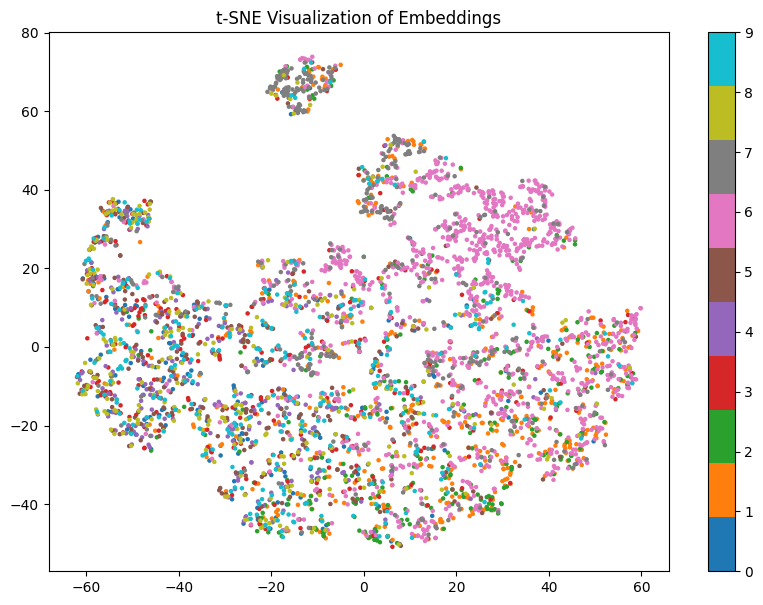

In [20]:
metrics = evaluate_model(model, test_loader, device, k=5)

In [ ]:
print(metrics)

{'Recall@K': 0.7408857352581355, 'mAP': 0.2836929424302793}


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()